In [ ]:
cd /content/drive/MyDrive/Data project (VITA)/Data/Synthetic_Data

/content/drive/MyDrive/Data project (VITA)/Data/Synthetic_Data


## Multivariate Time Series Classification LSTM PyTorch

In [ ]:
!pip install torch==1.10.0

In [ ]:
!pip install pytorch-lightning

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc 
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
#from pytorch_lightning.metrics.functional import accuracy 
from sklearn.metrics import classification_report, confusion_matrix
base_folder = '/content/drive/MyDrive/Data project (VITA)/'

In [ ]:
pl.seed_everything(42)

Global seed set to 42


42

## Loading data (1)

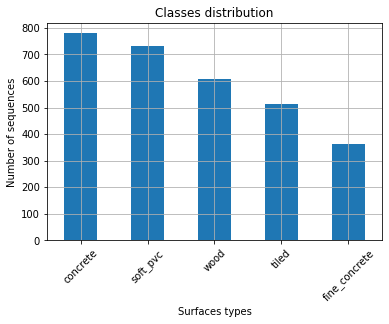

In [ ]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
surfaces_delete = ['hard_tiles', 'carpet', 'soft_tiles', 'hard_tiles_large_space']

# deleting classes with lowest number of samples
s, ht, c, htls, st = "surface", "hard_tiles", "carpet", "hard_tiles_large_space", "soft_tiles"
dropped = (y_train.loc[(y_train[s] == ht) | (y_train[s] == c) | (y_train[s] == htls) | (y_train[s] == st)])["series_id"].tolist()
y = y_train.loc[(y_train[s] != ht) & (y_train[s] != c) & (y_train[s] != htls) & (y_train[s] != st)]

X = X_train
for i in dropped:
    X = X.loc[X["series_id"] != i]

# new repartition of labels
y_train = y
X_train = X
y_train.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.grid()
plt.ylabel('Number of sequences')
plt.xlabel('Surfaces types')
plt.title('Classes distribution')
plt.show()

# Create sequences

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)
y_train["label"] = encoded_labels
features = X_train.columns.tolist()[3:]

sequences = []

for series_id, group in X_train.groupby("series_id"):
  sequence_features = group[features]
  label = y_train[y_train.series_id == series_id].iloc[0].label
  sequences.append((sequence_features, label))

train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

## Preprocessing

In [ ]:
features = X_train.columns.tolist()[3:]

In [ ]:
# All of the sequences have been already splitted for us
(X_train.series_id.value_counts() == 128).sum() == len(y_train)

True

In [ ]:
sequences = []

for series_id, group in X_train.groupby("series_id"):
  sequence_features = group[features]
  label = y_train[y_train.series_id == series_id].iloc[0].label
  sequences.append((sequence_features, label))

In [ ]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

## Train

In [ ]:
cd /content/drive/MyDrive/Data project (VITA)/codes

/content/drive/MyDrive/Data project (VITA)/codes


In [ ]:
from lstm_module import *
from project_utils import *

In [ ]:
# Set training parameters
num_epochs = 300
bsz = 25
data_module = InteractionsDataModule(train_sequences, test_sequences, bsz)
log_path = base_folder+'Data/robot_log'
model = InteractionsPredictor(
    n_features=len(features),
    n_classes=len(label_encoder.classes_), # without the class no_label
    train_len = len(train_sequences),
    test_len = len(test_sequences),
    bsz = bsz)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints", filename="best-checkpoint",
    save_top_k=1, verbose=True, monitor="val_loss", mode="min")

logger = TensorBoardLogger(log_path, name= "all_users")
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=num_epochs,
    gpus=1,
    progress_bar_refresh_rate=30
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff7d4496f90>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff7d4496f90>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

In [ ]:
trainer.fit(model, data_module)

In [ ]:
train_loss = model.loss_train
val_loss = model.loss_val
train_accuracy = model.acc_train
val_accuracy = model.acc_val
f1 = model.f1

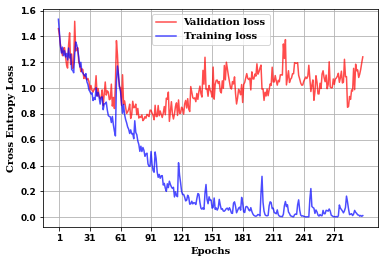

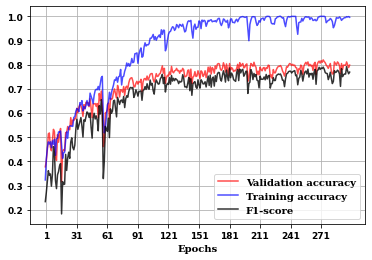

In [ ]:
plot_performance(base_folder, 'robot', len(train_loss), val_accuracy, train_accuracy, f1, train_loss, val_loss, save=False)

In [ ]:
model_path = base_folder+'Data/robot_log/models/model.pth'
torch.save(model.state_dict(),model_path)

## Test

In [ ]:
model = InteractionsPredictor(
    n_features=len(features),
    n_classes=len(label_encoder.classes_), # without the class no_label
    test_len = len(test_sequences),
    train_len = len(train_sequences),
    bsz = 25
    )
model.load_state_dict(torch.load(model_path))
model.model = model.best_weights
model.eval()

InteractionsPredictor(
  (model): SequenceModel(
    (lstm): LSTM(10, 256, num_layers=2, batch_first=True, dropout=0.75)
    (classifier): Linear(in_features=256, out_features=5, bias=True)
  )
  (criterion): CrossEntropyLoss()
  (best_weights): SequenceModel(
    (lstm): LSTM(10, 256, num_layers=2, batch_first=True, dropout=0.75)
    (classifier): Linear(in_features=256, out_features=5, bias=True)
  )
)

In [ ]:
# Test final model performance
dataloader_test = DataLoader(InteractionsDataset(test_sequences), batch_size = 25, shuffle = False,
        num_workers = cpu_count(),
        collate_fn=PadSequence()
    )
y_true = []
y_pred = []
model.to('cuda')
for i, batch in enumerate(dataloader_test):
    sequences, seq_lengths, labels = batch
    seq_pack = PACK(sequences, seq_lengths.to('cpu'), batch_first=True).to('cuda')
    outputs = model(seq_pack)
    predictions = torch.argmax(outputs[1], dim=1)
    y_true.extend(labels.to('cpu').data.numpy().astype(int))
    y_pred.extend(predictions.to('cpu').data.numpy().astype(int))

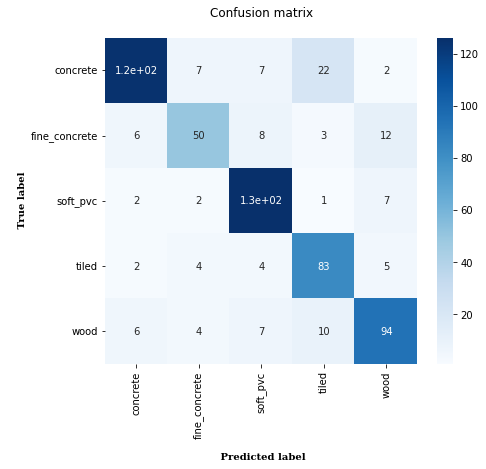

In [ ]:
plt.figure(figsize=(7,6))
cm = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('Confusion matrix\n');
ax.set_xlabel('\n Predicted label', fontsize=10, fontfamily='serif', fontweight = 'bold')
ax.set_ylabel('\n True label', fontsize=10, fontfamily='serif', fontweight = 'bold');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(label_encoder.classes_, rotation=90)
ax.yaxis.set_ticklabels(label_encoder.classes_, rotation=0)
plt.savefig(base_folder+'Results/'+'robot'+'_cm.png')
plt.show()

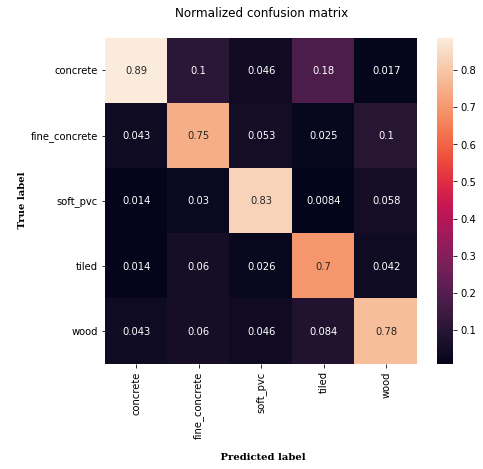

In [ ]:
plt.figure(figsize=(7,6))
cm = confusion_matrix(y_true, y_pred)
cm = cm/cm.astype(np.float).sum(axis=0)
ax = sns.heatmap(cm, annot=True)
ax.set_title('Normalized confusion matrix\n');
ax.set_xlabel('\n Predicted label', fontsize=10, fontfamily='serif', fontweight = 'bold')
ax.set_ylabel('\n True label', fontsize=10, fontfamily='serif', fontweight = 'bold');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(label_encoder.classes_, rotation=90)
ax.yaxis.set_ticklabels(label_encoder.classes_, rotation=0)
plt.savefig(base_folder+'Results/'+'robot'+'_cm_normalized.png')
plt.show()

In [ ]:
acc = sklearn.metrics.accuracy_score(y_pred, y_true)
f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
print('Final performance on test set: {:.3f} test accuracy and {:.3f} f1 score'.format(acc,f1))

Final performance on test set: 0.798 test accuracy and 0.784 f1 score
